<a href="https://colab.research.google.com/github/jamstanleyambe/End-to-End-Dog-Breed-Identification/blob/main/Dog_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐈 End-to-End multil-class Dog Breed Classification

This NoteBook builds an end to end multil-class image classifier using TensorFlow and TensorFlow Hub.

## 1. Problem


> Identifying the bread of a dog given an image of a dog.
if i can take a picture of any dog i want to know what kind of the breed the Dog is.

## 2. Data

>The data we are using is coming from Kaggle dog breed identification competition

## 3. Evaluation

> The Evaluation is a file with prediction probability of each dog breed of each test image

## 4. Features

>Some information about the data:
 * We are dealing with images **(unstructured data)** so it probably best to use deep learning/transfer learning.
 * There are 120 breeds of dogs (this means thee are 120 different classes).
 * There are around 10000 + images in the traing set ( this images has lable beacuse we are using them for the trainig)
 * Tehre are around 10000 + images in the test set, (this images has no lable because we want to predict them)


In [14]:
# Import necessary libraries for TensorFlow, data manipulation, and visualization
import tensorflow as tf  # Core library for deep learning
import tensorflow_hub as hub  # For using pre-trained models and modules
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced and statistical visualizations
import os  # For interacting with the operating system (e.g., file paths)
import shutil  # For file operations like copying or deleting
import random  # For generating random numbers or shuffling data
from IPython.display import Image  # For displaying images in a Jupyter/Colab environment

# Print versions of TensorFlow and TensorFlow Hub to ensure compatibility
print("tensorflow_hub", hub.__version__)  # Display TensorFlow Hub version
print("tensorflow", tf.__version__)  # Display TensorFlow version

tensorflow_hub 0.16.1
tensorflow 2.17.1


# Getting Our workPace Ready
* import Tensorflow
* import Tensorflow HandleData
* Make sure we're using GPU


In [15]:
# Check if a GPU is available for TensorFlow operations
# This is useful for ensuring that TensorFlow can leverage GPU acceleration, which is critical for deep learning tasks.
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


# getting our data ready (turning into Tensorns)
With all machine learning models, our data has to be in numerical format. So that well be doing first Turning our images into Tensors (numerical representation)

Lets start by accesssing our data and checking out the labels

In [16]:
# Load the dataset labels from a CSV file and inspect the first few rows
# This step helps us understand the structure of the data and verify that it has been loaded correctly.
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog Vision/dog-breed-identification/labels.csv")
labels_csv.head()  # Display the first 5 rows of the DataFrame

(                                 id             breed
 0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
 1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
 2  001cdf01b096e06d78e9e5112d419397          pekinese
 3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
 4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever,)

In [17]:
# Analyze the structure and summary statistics of the dataset
# These steps provide insights into the dataset's size, data types, missing values, and statistical properties.

# Check the shape of the dataset (number of rows and columns)
print(labels_csv.shape)  # Output: (rows, columns)

# Display information about the dataset, including column names, data types, and non-null counts
print(labels_csv.info())  # Useful for identifying missing values and understanding data types

# Generate descriptive statistics for numerical columns (e.g., count, mean, std, min, max)
print(labels_csv.describe())  # Provides a quick summary of the dataset's numerical features

(10222, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None
                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126


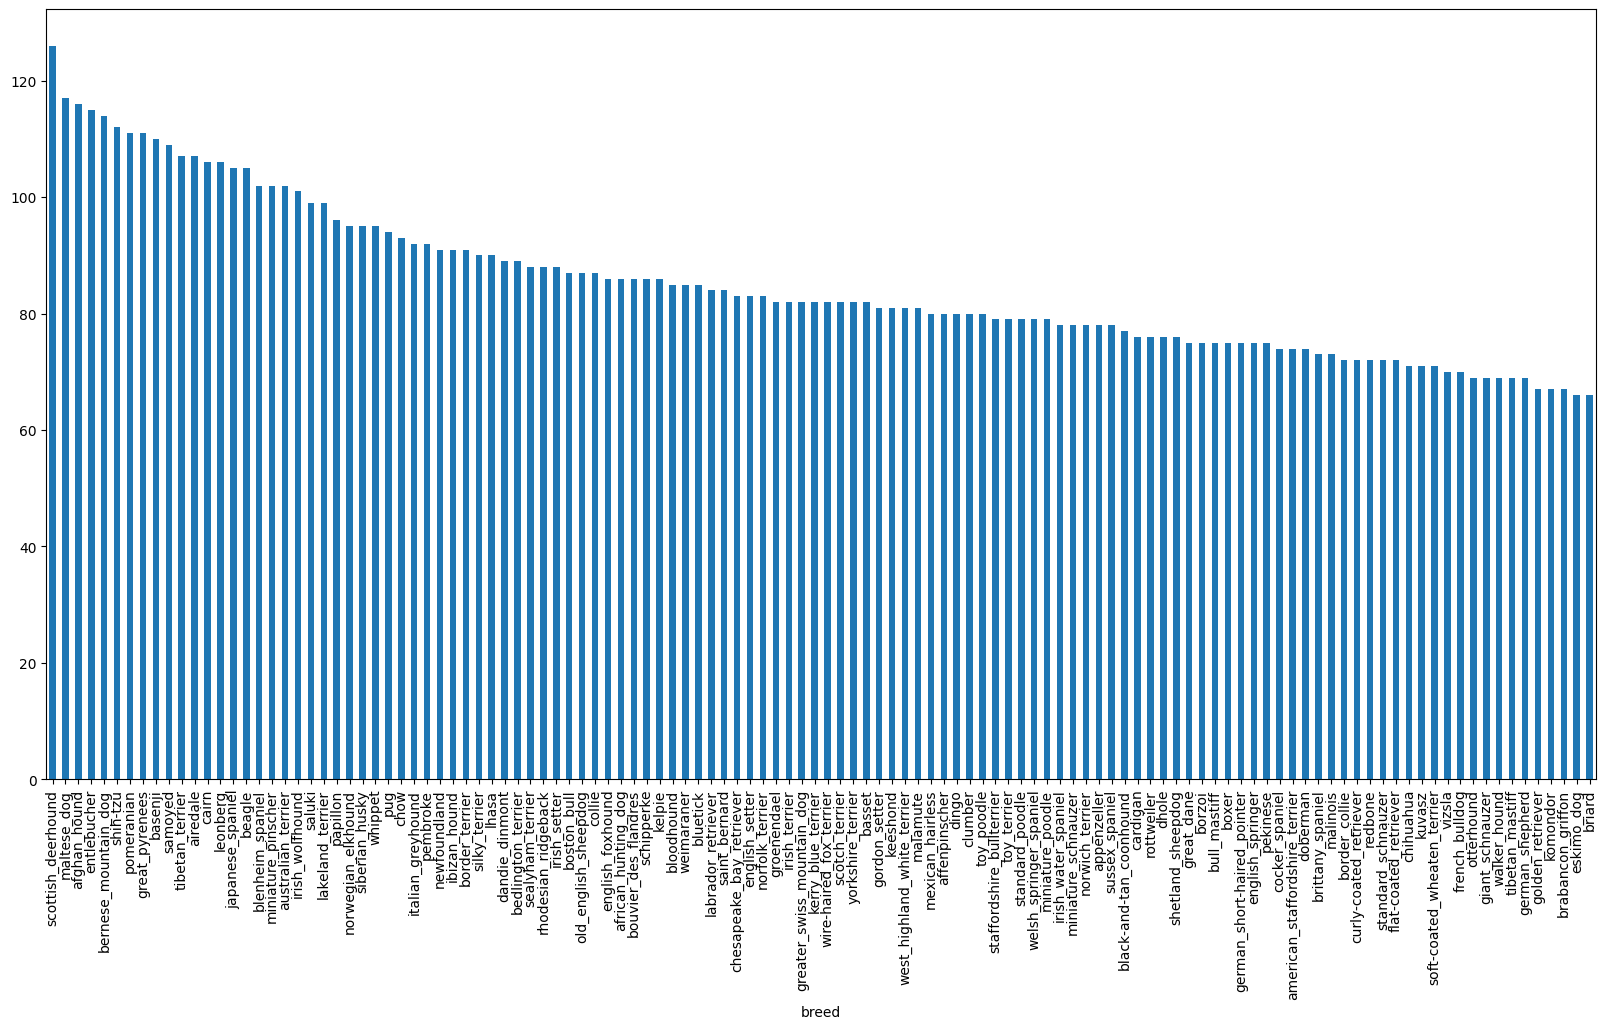

In [18]:
# Visualize the distribution of dog breeds in the dataset
# This step helps us understand the balance (or imbalance) of the dataset by counting and plotting the number of images per breed.

labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))  # Create a bar plot of breed counts
plt.xlabel("Breed")  # Label for the x-axis
plt.ylabel("Number of Images")  # Label for the y-axis
plt.title("Distribution of Dog Breeds in the Dataset")  # Title of the plot
plt.show()  # Display the plot

In [19]:
# Calculate the median number of images per breed in the dataset
# This metric provides insight into the central tendency of the dataset's class distribution,
# which is useful for understanding data balance and potential class imbalance issues.

median_images_per_breed = labels_csv['breed'].value_counts().median()
print("Median number of images per breed:", median_images_per_breed)

82.0

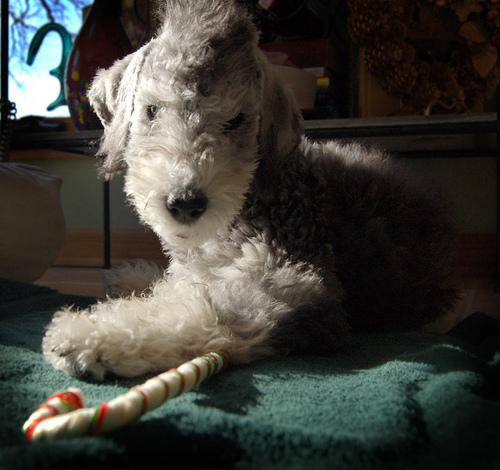

In [24]:
# Display an image from the dataset to visually inspect its content
# This step helps verify that the images are loaded correctly and provides a sense of the data's quality and format.

Image("/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg")

### Getting images and their labels
Let's get a list of all images file and pathnames

In [21]:
# Generate file paths for all images in the dataset using their unique IDs
# This step creates a list of full file paths by combining the base directory with each image's ID and file extension.
# It ensures that we can easily access and load the images for further processing or analysis.

filenames = ['/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/' + image_id + '.jpg' for image_id in labels_csv['id']]

In [22]:
# Inspect the first 10 file paths to ensure they have been generated correctly
# This step helps verify that the file paths are properly constructed and match the expected format.

filenames[:10]

['/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-

In [26]:
# Check the total number of image file paths generated
# This step ensures that the number of file paths matches the number of images in the dataset,
# helping to confirm that all images have been accounted for.

len(filenames)

10222

In [27]:
# Convert the 'breed' column from the DataFrame into a NumPy array
# This step prepares the labels in a format suitable for machine learning tasks,
# as many libraries (e.g., TensorFlow, scikit-learn) work efficiently with NumPy arrays.

labels = labels_csv['breed'].to_numpy()
labels  # Display the first few entries to verify the conversion

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [28]:
# Check the total number of labels in the dataset
# This step ensures that the number of labels matches the number of images,
# confirming that the dataset is complete and ready for further processing.

len(labels)

(10222,)

In [30]:
# Verify that the number of labels matches the number of image file paths
# This step ensures data consistency, confirming that each image has a corresponding label.
# A mismatch could indicate missing or misaligned data, which needs to be addressed before proceeding.

if len(labels) == len(filenames):
    print("Labels match the actual number of files! ✅")  # Success message if counts match
else:
    print("Labels do not match the actual number of files! ❌")  # Warning message if counts mismatch

labels match actual amount of files !!! 


In [34]:
# Extract and count the unique dog breeds in the dataset
# This step identifies the total number of distinct classes (breeds) in the dataset,
# which is essential for setting up the output layer of a classification model.

unique_breeds = np.unique(labels)  # Extract unique breed names
len(unique_breeds)  # Count the number of unique breeds

120

In [35]:
# Convert a single label into a boolean array indicating its match with unique breeds
# This step is useful for understanding how one-hot encoding works, which is commonly used in classification tasks.

print(labels[0])  # Display the first label for reference
labels[0] == unique_breeds  # Create a boolean array where True indicates a match with the unique breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [36]:
# Convert all labels into boolean arrays (one-hot encoding equivalent)
# This step transforms each label into a boolean array where the correct breed is marked as True and others as False.
# This format is useful for training machine learning models, especially in multi-class classification tasks.

boolean_labels = [label == np.array(unique_breeds) for label in labels]  # Create boolean arrays for all labels
boolean_labels[:2]  # Display the first two boolean arrays for verification

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [37]:
# Check the total number of boolean label arrays
# This step ensures that the conversion to boolean arrays was successful and that the number of labels matches the dataset size.

len(boolean_labels)

10222

In [38]:
# Demonstrate converting a boolean array back into an integer index
# This step shows how to retrieve the original label index from a boolean array,
# which is useful for interpreting model predictions or reversing one-hot encoding.

print(labels[0])  # Display the first label for reference
print(boolean_labels[0].argmax())  # Find the index of the True value in the boolean array
boolean_labels[0].argmax()  # Return the index (equivalent to the breed's position in unique_breeds)

boston_bull
19


19

In [41]:
# Example Turning boolean array into integers
print(labels[0]) #Original label
print(np.where((unique_breeds == labels[0]))) #index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 whee the sample label occurs



boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [42]:
# Demonstrate converting a boolean array into integers (0s and 1s)
# This step shows how to transform a boolean array into a binary format,
# which is often required for machine learning tasks like one-hot encoding.

print(labels[2])  # Display the third label for reference
print(boolean_labels[2].astype(int))  # Convert the boolean array to integers (True -> 1, False -> 0)

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# Creating our own Validation set
Since the dataset from Kaggle does not come with a validation set were going to create our own

In [ ]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: 'slider', min:1, max:1000}

In [43]:
# Set up X and Y variable
x = filenames
y = boolean_labels

We are going to start off experimenting with ~ 1000 images and increase as need.

In [49]:
# set number of images to use for experimenting
NUM_IMAGES = 1000

In [50]:
#let's Split our data into train and validation sets
from sklearn.model_selection import train_test_split
#split them into training and  validation of total size NUM_IMAGES
x_train, x_test, y_train, y_test = train_test_split(x[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

In [51]:
# Check the sizes of the training and testing datasets
# This step ensures that the data has been split correctly and helps verify the distribution of samples.

len(x_train), len(y_train), len(x_test), len(y_test)

(800, 800, 200, 200)

In [53]:
# Inspect the first few samples of the training data and labels
# This step helps verify the content and format of the data, ensuring it is correctly loaded and preprocessed.

x_train[:2], y_train[:2]  # Display the first two samples of features (x) and labels (y)

(['/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, 

# Preprocessing images (turuning images into Tensors)
To Preprocessing our images into Tensors we're going to write  a function which does a few things:
1. Take an image filename as input
2. Use TensorFlow to read the file and save it to a variable image
3. Turn our image (a jpg) into Tensors
4. Resize the images to be a shape of (224, 224)
5. Return the modified image

Before we do lets see what importing an images look like

In [54]:
# Coverting image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [57]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

# Now we know how and image looks like as a Tensors, Let's make a function to preprocess them

>1. Take an image filename as input

>2. Use TensorFlow to read the file and save it to a variable image

>3. Turn our image (a jpg) into Tensors

>4. Resize the images to be a shape of (224, 224)

>5. Return the modified image

In [59]:
# Dedine image size
IMG_SIZE = 224

#Create a function for preprocessing images
def process_image(image_path):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  #Read in an images file
  image = tf.io.read_file(image_path)

In [61]:
tensor = tf.io.read_file(filenames[2])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca